# overview of llc uplet parcel simulation

This notebook provides examples for the loading and postprocessing of numerical surface drifter simulations of 


In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from xhistogram.xarray import histogram

import mitequinox.utils as ut
import mitequinox.plot as pl
import mitequinox.parcels as pa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
from dask.distributed import Client, LocalCluster
if True:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=4)
else:
    cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.56:8787/status,
Dashboard: http://10.148.1.56:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.56:52765,Workers: 0
Dashboard: http://10.148.1.56:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---
## load data

Conventions for simulation names are for the example of the `global_dij8_up3_r1s111_15j` simulation:

- `global`: simulation over the whole globe
- `dij8`: one uplet every 8 model grid points (model grid size between 1 and 2km)
- `up3`: 3 drifters per uplet
- `r1s111`: all drifters are evenly distributed on a circle of radius 1/111 deg (approx. 1km)
- `15j`: 15 day long simulation


In [3]:
root_dir = os.path.join(ut.work_data_dir,"parcels") 

# select a numerical simulation
run_name = "global_dij8_up3_r2s111_15j"

# and load
ds_info, dirs = pa.load_logs(root_dir, run_name)
_zarr = os.path.join(dirs["parquets"], "uplet.zarr")
ds_up = xr.open_zarr(_zarr).persist()

ds_up["lon"] = ds_up.lon%360
ds_up["lon_init_uplet"] = ds_up.lon_init_uplet%360
ds_up = ds_up.assign_coords(timed=(ds_up.time-ds_up.time[0])/pd.Timedelta("1D"))

---
## overview of geographical distribution and dispersion

The dataset has the following dimensions:

- `item`: drifter identifier within each uplet
- `uplet`: uplet identifier
- `time`: time dimension

Variables (sorted by order, see the [following notebook](https://github.com/apatlpo/mit_equinox/blob/master/parcels/uplet_build_zarr.ipynb) for the ugly details):

| **variables**  |  **description** |
| :-|:-|
| lon, lat |  longitude, latitude coordinates of each drifter  |
| lon_init_uplet, lat_init_uplet  |  uplet initial coordinates |
| time |  time as a date  |
| timed |  time as the number of days since the start of the lagrangian uplet simulation  |
| sea_level, temperature, salinity, zonal velocity, meridional_velocity, water_depth  | llc4320 model variables interpolated along drifter trajectories |
| x, y | locally projected horizontal coordinates, units are meters ! the projection varies from one uplet to another ! |
| x_m, y_m  | coordinates of each uplet center of mass  |
|  dl | separation between each drifter and the uplet center of mass |
|  dl_m |  averaged of dl within each uplet |
| traj  |  parcels drifter id number |
| obs  |  index since start of the lagrangian uplet simulation, probably useless |
| z | depth (constant=0), useless  |


### inspect dataset

In [6]:
ds_up

<xarray.Dataset>
Dimensions:              (uplet: 1976343, item: 3, time: 360)
Coordinates:
  * item                 (item) int64 0 1 2
    lat_init_uplet       (uplet) float64 dask.array<chunksize=(1976343,), meta=np.ndarray>
    lon_init_uplet       (uplet) float64 dask.array<chunksize=(1976343,), meta=np.ndarray>
  * time                 (time) datetime64[ns] 2012-02-01 ... 2012-02-15T23:0...
  * uplet                (uplet) int64 0 1 2 3 ... 54031109 54031110 54031111
    timed                (time) float64 0.0 0.04167 0.08333 ... 14.92 14.96
Data variables: (12/19)
    dl                   (uplet, item, time) float64 dask.array<chunksize=(8339, 3, 360), meta=np.ndarray>
    dl_uplet             (uplet, time) float64 dask.array<chunksize=(25017, 360), meta=np.ndarray>
    lat                  (item, uplet, time) float32 dask.array<chunksize=(3, 58253, 192), meta=np.ndarray>
    lat_m                (uplet, time) float64 dask.array<chunksize=(25017, 360), meta=np.ndarray>
    lon                  (item, uplet, time) float32 dask.array<chunksize=(3, 58253, 192), meta=np.ndarray>
    lon_m                (uplet, time) float64 dask.array<chunksize=(25017, 360), meta=np.ndarray>
    ...                   ...
    x                    (uplet, item, time) float64 dask.array<chunksize=(8339, 3, 360), meta=np.ndarray>
    x_m                  (uplet, time) float64 dask.array<chunksize=(25017, 360), meta=np.ndarray>
    y                    (uplet, item, time) float64 dask.array<chunksize=(8339, 3, 360), meta=np.ndarray>
    y_m                  (uplet, time) float64 dask.array<chunksize=(25017, 360), meta=np.ndarray>
    z                    (item, uplet, time) float32 dask.array<chunksize=(3, 58253, 192), meta=np.ndarray>
    zonal_velocity       (item, uplet, time) float32 dask.array<chunksize=(3, 25017, 360), meta=np.ndarray>

### release count

Count the number of uplets at release time in boxes of 1 deg by 1 deg.

In [ ]:
dl = 1
lon_bins = np.arange(0,360,dl)
lat_bins = np.arange(-80,80,dl)

In [8]:
N = histogram(ds_up.lon_init_uplet.rename("lon"), 
              ds_up.lat_init_uplet.rename("lat"), 
              bins=[lon_bins, lat_bins], 
              bin_dim_suffix="")
N = N.where(N>0)

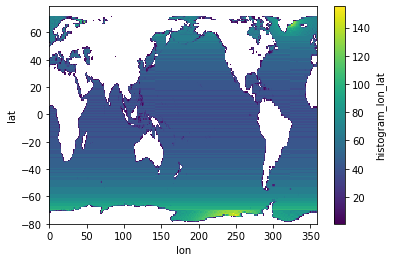

In [9]:
N.plot(x="lon")

#### zonally average count

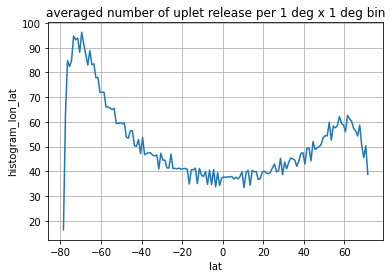

In [22]:
fig, ax = plt.subplots(1,1)
N.mean("lon").plot()
ax.set_title("averaged number of uplet release per 1 deg x 1 deg bin")
ax.grid()

### relative dispersion overview

For each uplet, average the separation with the center of mass squared.

Note this should be close to `dl_uplet` which is the average of the separation (i.e. not squared)


In [24]:
T = 5
_ds = ds_up.isel(time=24*T)
dl2 = (_ds.dl**2).mean("item")

In [25]:
D = histogram(ds_up.lon_init_uplet.rename("lon"), 
              ds_up.lat_init_uplet.rename("lat"), 
              bins=[lon_bins, lat_bins], 
              weights=dl2,
              bin_dim_suffix="")
D = (D/N).where(D>0).compute()

Text(0.5, 0, '[km]')

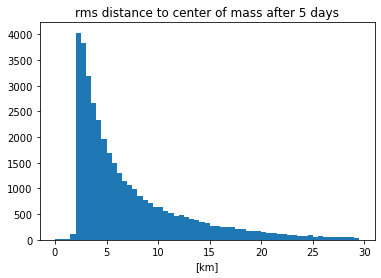

In [26]:
fig, ax = plt.subplots(1,1)
(np.sqrt(D)/1e3).plot.hist(bins=np.arange(0,30,0.5));
ax.set_title(f"rms distance to center of mass after {T} days")
ax.set_xlabel("[km]")

Text(0.5, 1.0, 'rms distance to center of mass after 5 days')

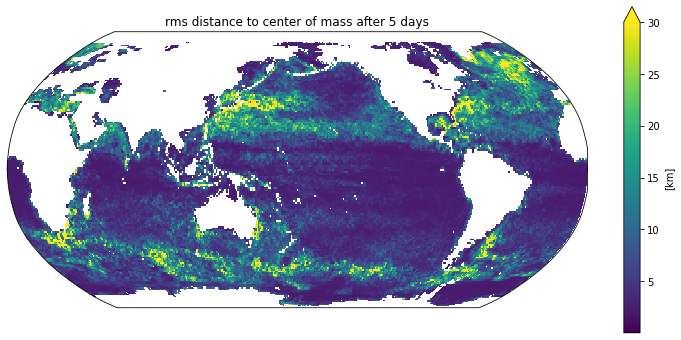

In [27]:
fig = plt.figure(figsize=(13,6))

ax = plt.axes(projection=pl.ccrs.Robinson(central_longitude=180))

_hdl = (np.sqrt(D)/1e3).plot(x="lon", vmax=30, transform=pl.ccrs.PlateCarree())
_hdl.colorbar.set_label("[km]")

ax.set_title(f"rms distance to center of mass after {T} days")


#### compute a global average of the separation squared at each time step

In [31]:
dl2_mean = (ds_up.dl**2).mean(["item","uplet"]).compute()

Text(0.5, 0, 'time [days]')

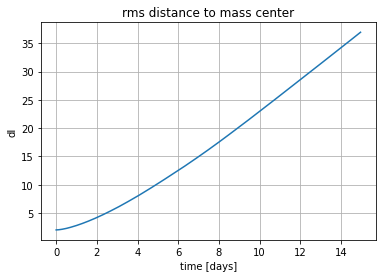

In [32]:
fig, ax = plt.subplots(1,1)
(np.sqrt(dl2_mean)/1e3).plot(x="timed")
ax.grid()
ax.set_title("rms distance to mass center")
ax.set_xlabel("time [days]")
#ax.set_xscale("log")
#ax.set_yscale("log")

### show the distribution of separation as a function of time

In [33]:
dl_bins = np.arange(0,100,1)

N_D = histogram(ds_up.dl/1e3, 
               bins=[dl_bins],
               dim=["uplet", "item"],
               bin_dim_suffix="")
#Dt = (Dt/N).where(D>0).compute()
N_D = N_D.assign_coords(timed=ds_up.timed).compute()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


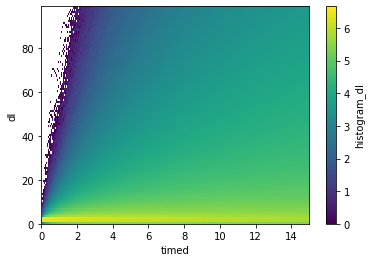

In [34]:
np.log10(N_D).plot(x="timed")

### !to do: kinetic energy

- Average kinetic energy in 1 deg by 1 deg bins and show the histogram as well as a map
- Average kinetic energy in 1 deg by 1 deg bins at each time and show different snapshots of binned energy

### show a couple of uplet trajectories examples

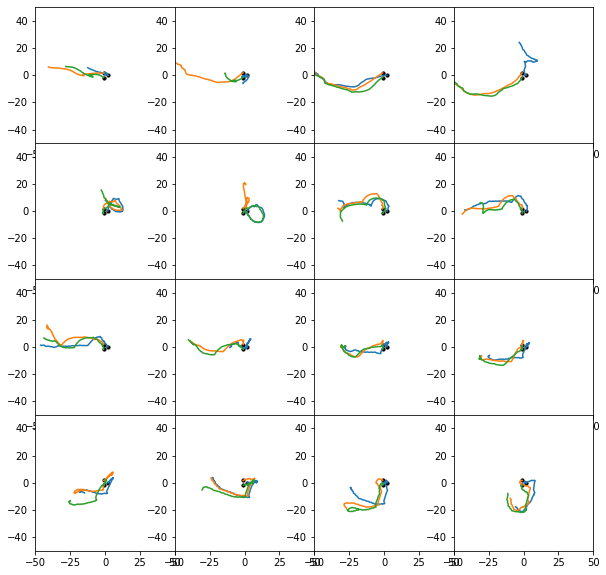

In [35]:
fig = plt.figure(figsize=(10, 10), constrained_layout=False)

Nx, Ny = 4,4
grid = fig.add_gridspec(4, 4, wspace=0, hspace=0)

for i in range(Nx):
    for j in range(Ny):
        _ds = ds_up.isel(uplet=i*Nx+j)
        ax = fig.add_subplot(grid[i,j])
        x = (_ds.x - _ds.x_m[0])/1e3
        y = (_ds.y - _ds.y_m[0])/1e3
        ax.scatter(x.isel(time=0).T, y.isel(time=0).T, s=10, marker="o", color="k")
        ax.plot(x.T, y.T)
        ax.set_xlim(-50,50)
        ax.set_ylim(-50,50)

### spaghettis on a map, illustrates data density

Note the horizontal grid of the model is distributed over 13 different faces (or tile) (we select face 7 here).
For each face (tile), dimensions i and j correspond to horizontal dimensions.

We load `SST` but other variables are available: `Eta` (sea level), `SST`, `SSS`, `SSU` (current in i direction), `SSV` (current in j direction)

In [37]:
# load the model simulation for face 7 llc4320
face = 7

ds = ut.load_data(["SST"]).sel(time=ds_up.time)
grd = ut.load_grd(["XC", "YC"])
ds = xr.merge([ds.sel(face=face), grd.sel(face=face)])
ds["XC"] = ds.XC%360

ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:  (time: 360, j: 4320, i: 4320)
Coordinates:
    face     int64 7
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(128,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-02-15T23:00:00
    timed    (time) float64 0.0 0.04167 0.08333 0.125 ... 14.88 14.92 14.96
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Data variables:
    SST      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

#### Narrow horizontally the model data

In [4]:
# geographic bounding box
llon, llat, dtick = [145, 180], [15, 40], 5
llon, llat, dtick = [155, 165], [25, 35], 2
llon, llat, dtick = [155, 160], [25, 30], 1

In [39]:
ds_up_zoom = (ds_up.where( (ds_up.lon>llon[0]) & (ds_up.lon<llon[1]) 
                          & (ds_up.lat>llat[0]) & (ds_up.lat<llat[1]), 
                          drop=True)
              .persist()
             )

#### and plot

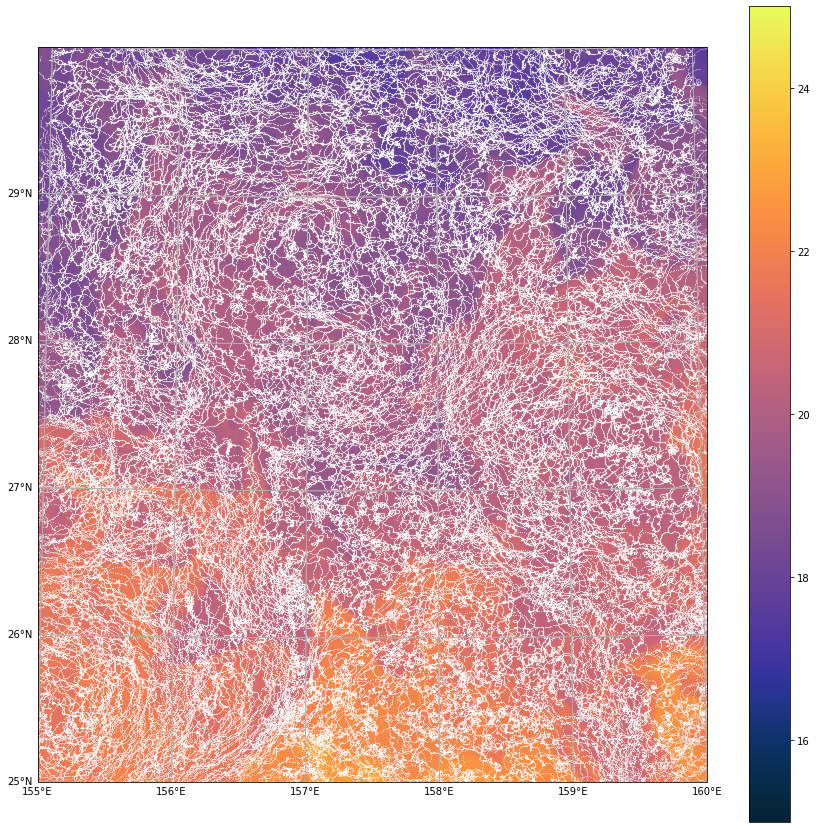

In [41]:
_ext = llon+llat
region= dict(faces=[7], 
             extent=_ext,
             dticks=[5, 5],
             projection=ccrs.LambertAzimuthalEqualArea(central_longitude=(llon[0]+llon[1])*.5, 
                                                       central_latitude=(llat[0]+llat[1])*.5,
                                                      )
            )

fac = pl.plot_pretty(ds.SST.isel(time=-1), vmin=15, vmax=25,
                     region=region, gridlines=False, colorbar=True)

# fix grid lines
ax = fac["ax"]
dtick = 1
gl = ax.gridlines(crs=pl.ccrs.PlateCarree(), 
                  xlocs=np.arange(llon[0], llon[1]+dtick, dtick),
                  ylocs=np.arange(llat[0], llat[1]+dtick, dtick),
                  #x_inline=True,
                  #y_inline=True,
                  draw_labels=True,
                 )
gl.top_labels = False
gl.right_labels = False

# uplet center of mass
ds_up_zoom.plot.scatter(x="lon_m", y="lat_m", s=0.01, color="w", ax=ax, transform=pl.ccrs.PlateCarree())

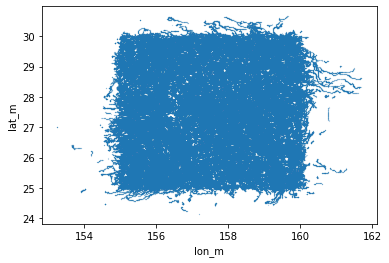

In [42]:
ds_up_zoom.plot.scatter(x="lon_m", y="lat_m", s=0.01)

## Close cluster

In [16]:
cluster.close()